## For colab, content and style files need to be uploaded before proceed to the next section

## Import

In [1]:
%tensorflow_version 2.x
from google.colab import files
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline

TensorFlow 2.x selected.


In [2]:
print(f'tf version: {tf.__version__}')

tf version: 2.0.0


## Load and pre-process images

In [0]:
def load_preprocessing_img(path):
    '''
    preprocess the image array into a normalized 4-D tensor
    '''
    dim_thresh = 512
    img = cv2.imread(path)
    img = img.astype('float32')
    img /= 255.
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    scale = dim_thresh/max(img.shape)
    scaled = (int(img.shape[1]*scale),int(img.shape[0]*scale))
    img = cv2.resize(img,scaled)
    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis,:]
    return img

In [0]:
content = load_preprocessing_img('sean.jpg')
style = load_preprocessing_img('the-weeping-woman-by-pablo-picasso.jpg')

In [5]:
print('content size: {}'.format(content.shape))
print('style size: {}'.format(style.shape))

content size: (1, 512, 380, 3)
style size: (1, 512, 420, 3)


In [6]:
vgg = keras.applications.VGG16(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layers = ['block5_conv2']

In [0]:
def vgg_layers_extractor(layers):
    vgg = keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layers]
    model = keras.Model([vgg.input], outputs)
    return model

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [0]:
class StyleTransferModel(keras.models.Model):
    def __init__(self,style_layers,content_layers):
        super(StyleTransferModel,self).__init__()
        self.vgg_model = vgg_layers_extractor(style_layers+content_layers)
        self.vgg_model.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
    
    def call(self, img):
        img = keras.applications.vgg16.preprocess_input(img*255.)
        results = self.vgg_model(img)
        style_results = results[:-1]
        style_results = [gram_matrix(style_result) for style_result in style_results]
        content_results = results[-1:]
        
        style_map = {name:val for name,val in zip(self.style_layers,style_results)}
        content_map = {name:val for name,val in zip(self.content_layers,content_results)}

        return {'style':style_map,'content':content_map}

In [11]:
extractor = StyleTransferModel(style_layers,content_layers)
results = extractor(content)

print('<<Style shape>>')
for i in results['style']:
    print(results['style'][i].shape)
print()
print('<<Content shape>>')
for i in results['content']:
    print(results['content'][i].shape)

<<Style shape>>
(1, 64, 64)
(1, 128, 128)
(1, 256, 256)
(1, 512, 512)
(1, 512, 512)

<<Content shape>>
(1, 32, 23, 512)


In [0]:
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [0]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

In [0]:
def custom_loss(results,style_targets,content_targets):
    style_original = results['style']
    content_original = results['content']
    
    style_loss = tf.add_n([tf.reduce_mean(tf.square(style_original[name]-style_targets[name])) for name in style_original])
    style_loss *= style_weight/len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_original[name]-content_targets[name])) for name in content_original])
    content_loss *= content_weight/len(content_layers)
    
    loss = style_loss + content_loss
    return loss

In [0]:
optimizer = keras.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)
@tf.function()
def training(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = custom_loss(outputs,style_targets,content_targets)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss,image)
    optimizer.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))

In [0]:
def tensor_to_array(tensor):
    tensor = tensor * 255
    array = tensor.numpy().astype(int)
    array = array[0]
    return array

In [0]:
content_image = tf.Variable(content)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [0]:
def transform(epochs,content_image):
  transforming_images = []
  print('training begins: ', end='')
  for n in range(epochs+1):
    if n != 0:
      training(content_image)
    if n%10 == 0:
      transforming_images.append(content_image)
      plt.figure(figsize=(7,7))
      plt.imshow(tensor_to_array(content_image))
      plt.title('epoch-{}'.format(n),fontsize=18,fontweight='bold')
      plt.axis('off')
      # plt.savefig('style transfer @ epoch-{}.png'.format(n),bbox_inches='tight',dpi=100)
      # files.download('style transfer @ epoch-{}.png'.format(n)) 
      plt.close()
    if n%100 == 0:
      print('/'+str(n)+'/')
    if n != epochs:
      print(".", end='')

In [19]:
epochs = 1000
transform(epochs,content_image)

training begins: /0/
..................................................................................................../100/
..................................................................................................../200/
..................................................................................................../300/
..................................................................................................../400/
..................................................................................................../500/
..................................................................................................../600/
..................................................................................................../700/
..................................................................................................../800/
..................................................................................................../900/
.........................

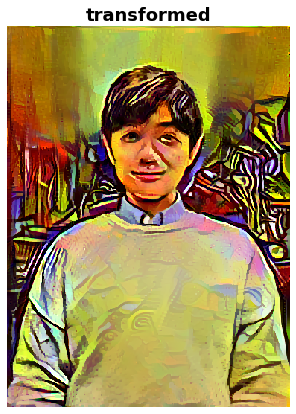

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(tensor_to_array(content_image))
plt.title('transformed',fontsize=18,fontweight='bold')
plt.axis('off')
plt.show()

## testing - style transfer to mona lisa

In [0]:
fig,axes = plt.subplots(1,2,figsize=(10,10))
for ax,img,title in zip(axes,[content,style],['Original','Style']):
    ax.imshow(img[0])
    ax.axis('off')
    ax.set_title(title,fontsize=18,fontweight='bold')

In [0]:
hub_module = tf_hub.load(style_transfer_TFHub_URL)
result = hub_module(tf.constant(content),tf.constant(style))[0]

In [0]:
def tensor_to_array(tensor):
    tensor = tensor * 255
    array = tensor.numpy().astype(int)
    array = array[0]
    return array

In [0]:
plt.figure(figsize=(7,7))
plt.imshow(tensor_to_array(result))
plt.title('scream-style',fontsize=18,fontweight='bold')
plt.axis('off')
plt.show()

## testing - style transfer

In [0]:
file_list = ['LesDemoisellesdAvignon-by-pablo-picasso','Goguryeo_tomb_mural','no-1-lavender-mist-by-jackson-pollock','starry-night-by-vincent-van-gogh','the-kiss-by-gustav-klimt','the-persistence-of-memory-by-salvador-dali','the-scream-by-edvard-munch','the-weeping-woman-by-pablo-picasso','water-lily-pond-by-claude-monet']
title_list = ['Avignon','TombMural','LavenderMist','StarryNight','Kiss','PersistenceOfMemory','Scream','WeepingWoman','WaterLilyPond']
style_list = [load_preprocessing_img(os.path.join('styles',file+'.jpg')) for file in file_list]

In [0]:
fig,axes = plt.subplots(3,3,figsize=(10,10))
for ax,style,title in zip(axes.flatten(),style_list,title_list):
    ax.imshow(style[0])
    ax.axis('off')
    ax.set_title(title,fontweight='bold')
plt.tight_layout()

In [0]:
result_list = [hub_module(tf.constant(content),tf.constant(style))[0] for style in style_list]

In [0]:
fig,axes = plt.subplots(3,3,figsize=(8*1.5,12*1.5))
for ax,result,title in zip(axes.flatten(),result_list,title_list):
    ax.imshow(result[0])
    ax.axis('off')
    ax.set_title(title,fontweight='bold')
fig.subplots_adjust(wspace=0,hspace=0.05)

## art <--> art style transfer

In [0]:
def plot_style_transfer(content_path,content_title,style_path,style_title):
    content = load_preprocessing_img(content_path)
    style = load_preprocessing_img(style_path)
    hub_module = tf_hub.load(style_transfer_TFHub_URL)
    result = hub_module(tf.constant(content),tf.constant(style))[0]
    title = '{} drawn with {} style'.format(content_title,style_title)
    plt.figure(figsize=(7,7))
    plt.imshow(tensor_to_array(result))
    plt.title(title,fontsize=18,fontweight='bold')
    plt.axis('off')
    plt.show()

In [0]:
content_path = 'styles/Goguryeo_tomb_mural.jpg'
style_path = 'styles/the-weeping-woman-by-pablo-picasso.jpg'
plot_style_transfer(content_path,'Korean Tomb Mural',style_path,'Weeping Woman')

In [0]:
content_path = 'styles/starry-night-by-vincent-van-gogh.jpg'
style_path = 'styles/the-persistence-of-memory-by-salvador-dali.jpg'
plot_style_transfer(content_path,'Starry night',style_path,'Persistence of memory')